In [1]:
library(dplyr)
library(purrr)
library(tidyr)
library(ggplot2)
library(broom)
library(magrittr)
library(RSQLite)
library(reshape2)
library(jsonlite)
library(knitr)
library(FNN)
library(grid)
library(gridExtra)
library (cluster)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'purrr'

The following objects are masked from 'package:dplyr':

    contains, order_by

Warning message:
"package 'ggplot2' was built under R version 3.3.3"
Attaching package: 'magrittr'

The following object is masked from 'package:tidyr':

    extract

The following object is masked from 'package:purrr':

    set_names


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths


Attaching package: 'jsonlite'

The following object is masked from 'package:purrr':

    flatten

Warning message:
"package 'FNN' was built under R version 3.3.3"Warning message:
"package 'gridExtra' was built under R version 3.3.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



######  Steps : Cleaning and Munging <br/>
1) Read data from csv<br/><br/>
2) Rename columns for better redability : <br/><br/>
&emsp;&emsp;&emsp;      sampleid=ï..psraid<br/><br/>
&emsp;&emsp;&emsp;      Internet_Service_at_Home=home4nw<br/><br/>
&emsp;&emsp;&emsp;      Type_of_Net=bbhome1<br/><br/>
&emsp;&emsp;&emsp;      Television_Connection=cable2<br/><br/>
&emsp;&emsp;&emsp;      Education_Level=educ2<br/><br/>
&emsp;&emsp;&emsp;      NoSmartPhones=q4<br/><br/>
&emsp;&emsp;&emsp;      Violentgames=game3b<br/><br/>
&emsp;&emsp;&emsp;      OnlineDatingA=date4a<br/><br/>
3) Change all columns containing integers to factors.<br/><br/>

In [2]:
library(dplyr)
GJB <- read.csv(file="GJBCSV.csv", header=TRUE) #Read data from csv
gjb.data=GJB %>%
rename(sampleid=ï..psraid)%>%
rename(internet_service_at_home=home4nw)%>%
rename(type_of_net=bbhome1)%>%
rename(television_connection=cable2)%>%
rename(education_level=educ2)%>%
rename(violentgames=game3b)%>%
rename(onlinedating=date4a)%>%
rename(income=inc)%>%
mutate_if(is.integer,as.numeric)    #Change all columns containing integers to factors.
# head(gjbfactorize)


Filtering the unknown 98/8 didnot answer 99/9 data

In [3]:
names(gjb.data) <- tolower(names(gjb.data))
# gjb.data.select<-select(gjb.data,age,sex,education_level,income,marital,internet_service_at_home,state,emplnw)
gjb.data.select<-select(gjb.data,age,state,education_level,emplnw,income,internet_service_at_home)
gjb.data.select=na.omit(gjb.data.select)
# gjb.data.select=filter(gjb.data.select,age<98 & education_level<97 & income<97 & internet_service_at_home <8 & marital < 8,emplnw<98)
gjb.data.select=filter(gjb.data.select,age<98 & education_level<97
                       & income<97 & emplnw<98,internet_service_at_home<8)

In [4]:
lapply(gjb.data.select, unique)

$age
 [1] 63 40 65 69 77 52 74 44 87 58 31 70 36 39 85 76 66 57 19 28 49 45 75 60 67
[26] 80 73 81 51 78 61 37 43 82 72 59 56 91 54 34 55 62 46 33 83 22 53 18 79 71
[51] 64 86 35 21 68 50 32 48 26 27 84 47 30 42 20 89 38 24 88 25 23 29 41

$state
 [1] 24 37 21 20 40 27 12  1  5 30  9 51 49 53 41  6 39 55 29 23 26 15 42 34 54
[26] 17 36 48 46 35 18 25 33 31 45 13 47 38 19 32  4 22  2 44  8 11 50 28 10 16
[51] 56

$education_level
[1] 4 5 6 3 8 7 2 1

$emplnw
[1] 3 1 2 4 6 5 7 8

$income
[1] 6 3 8 7 4 2 9 1 5

$internet_service_at_home
[1] 1 2

In [5]:
summary(gjb.data.select)

      age            state       education_level     emplnw     
 Min.   :18.00   Min.   : 1.00   Min.   :1.000   Min.   :1.000  
 1st Qu.:33.00   1st Qu.:13.00   1st Qu.:3.000   1st Qu.:1.000  
 Median :49.00   Median :29.00   Median :5.000   Median :1.500  
 Mean   :47.83   Mean   :28.46   Mean   :5.113   Mean   :2.128  
 3rd Qu.:61.00   3rd Qu.:42.00   3rd Qu.:6.000   3rd Qu.:3.000  
 Max.   :91.00   Max.   :56.00   Max.   :8.000   Max.   :8.000  
     income      internet_service_at_home
 Min.   :1.000   Min.   :1.000           
 1st Qu.:3.000   1st Qu.:1.000           
 Median :6.000   Median :1.000           
 Mean   :5.366   Mean   :1.139           
 3rd Qu.:7.000   3rd Qu.:1.000           
 Max.   :9.000   Max.   :2.000           

# To improve predictive accuracy and not allow a particular feature impact the prediction due to large numeric value range we apply Min Max normalization method

### Approach 1:  Min Max normalizaion

Defining a min max normalizing function

In [6]:
normalize <- function(x) {
    return ((x - min(x)) / (max(x) - min(x)))
  }

All the data points are proportionally squeezed between 0 and 1

In [7]:
gjb.data.select.normalized=as.data.frame(lapply(gjb.data.select[,1:5], normalize))#Normalize alll feature except label
lapply(gjb.data.select.normalized, unique)


$age
 [1] 0.61643836 0.30136986 0.64383562 0.69863014 0.80821918 0.46575342
 [7] 0.76712329 0.35616438 0.94520548 0.54794521 0.17808219 0.71232877
[13] 0.24657534 0.28767123 0.91780822 0.79452055 0.65753425 0.53424658
[19] 0.01369863 0.13698630 0.42465753 0.36986301 0.78082192 0.57534247
[25] 0.67123288 0.84931507 0.75342466 0.86301370 0.45205479 0.82191781
[31] 0.58904110 0.26027397 0.34246575 0.87671233 0.73972603 0.56164384
[37] 0.52054795 1.00000000 0.49315068 0.21917808 0.50684932 0.60273973
[43] 0.38356164 0.20547945 0.89041096 0.05479452 0.47945205 0.00000000
[49] 0.83561644 0.72602740 0.63013699 0.93150685 0.23287671 0.04109589
[55] 0.68493151 0.43835616 0.19178082 0.41095890 0.10958904 0.12328767
[61] 0.90410959 0.39726027 0.16438356 0.32876712 0.02739726 0.97260274
[67] 0.27397260 0.08219178 0.95890411 0.09589041 0.06849315 0.15068493
[73] 0.31506849

$state
 [1] 0.41818182 0.65454545 0.36363636 0.34545455 0.70909091 0.47272727
 [7] 0.20000000 0.00000000 0.07272727 0.52727273 0.14545455 0.90909091
[13] 0.87272727 0.94545455 0.72727273 0.09090909 0.69090909 0.98181818
[19] 0.50909091 0.40000000 0.45454545 0.25454545 0.74545455 0.60000000
[25] 0.96363636 0.29090909 0.63636364 0.85454545 0.81818182 0.61818182
[31] 0.30909091 0.43636364 0.58181818 0.54545455 0.80000000 0.21818182
[37] 0.83636364 0.67272727 0.32727273 0.56363636 0.05454545 0.38181818
[43] 0.01818182 0.78181818 0.12727273 0.18181818 0.89090909 0.49090909
[49] 0.16363636 0.27272727 1.00000000

$education_level
[1] 0.4285714 0.5714286 0.7142857 0.2857143 1.0000000 0.8571429 0.1428571
[8] 0.0000000

$emplnw
[1] 0.2857143 0.0000000 0.1428571 0.4285714 0.7142857 0.5714286 0.8571429
[8] 1.0000000

$income
[1] 0.625 0.250 0.875 0.750 0.375 0.125 1.000 0.000 0.500

Checking the values after normalition

In [8]:
summary(gjb.data.select.normalized)

      age             state        education_level      emplnw       
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.2055   1st Qu.:0.2182   1st Qu.:0.2857   1st Qu.:0.00000  
 Median :0.4247   Median :0.5091   Median :0.5714   Median :0.07143  
 Mean   :0.4086   Mean   :0.4993   Mean   :0.5875   Mean   :0.16120  
 3rd Qu.:0.5890   3rd Qu.:0.7455   3rd Qu.:0.7143   3rd Qu.:0.28571  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.00000  
     income      
 Min.   :0.0000  
 1st Qu.:0.2500  
 Median :0.6250  
 Mean   :0.5458  
 3rd Qu.:0.7500  
 Max.   :1.0000  

Now all the values fall under common range

<h3>Let the labels be answers to the question </h3>
Do you have internet service at home? <br>
Answers are Yes=1,No=2<br>
We are trying to observe how the kmeans labels the data? which one to yes, which one to no

Seperating label and data

In [9]:
cl=gjb.data.select$internet_service_at_home
#holds label
data.feature=gjb.data.select.normalized#holds features
head(cl)# holds label
head(data.feature)#holds features normalized

[1] 1 1 1 1 1 1

age,state,education_level,emplnw,income
0.6164384,0.4181818,0.4285714,0.2857143,0.625
0.3013699,0.6545455,0.5714286,0.0000000,0.625
0.6438356,0.3636364,0.4285714,0.2857143,0.250
0.6986301,0.3454545,0.7142857,0.1428571,0.875
0.8082192,0.7090909,0.7142857,0.2857143,0.625
0.4657534,0.4727273,0.4285714,0.0000000,0.875


# Analyzing for k=3

In [10]:
kmeans_default.3=kmeans.gjb<-kmeans(data.feature,3)
summary(kmeans_default.3)

             Length Class  Mode   
cluster      1472   -none- numeric
centers        15   -none- numeric
totss           1   -none- numeric
withinss        3   -none- numeric
tot.withinss    1   -none- numeric
betweenss       1   -none- numeric
size            3   -none- numeric
iter            1   -none- numeric
ifault          1   -none- numeric

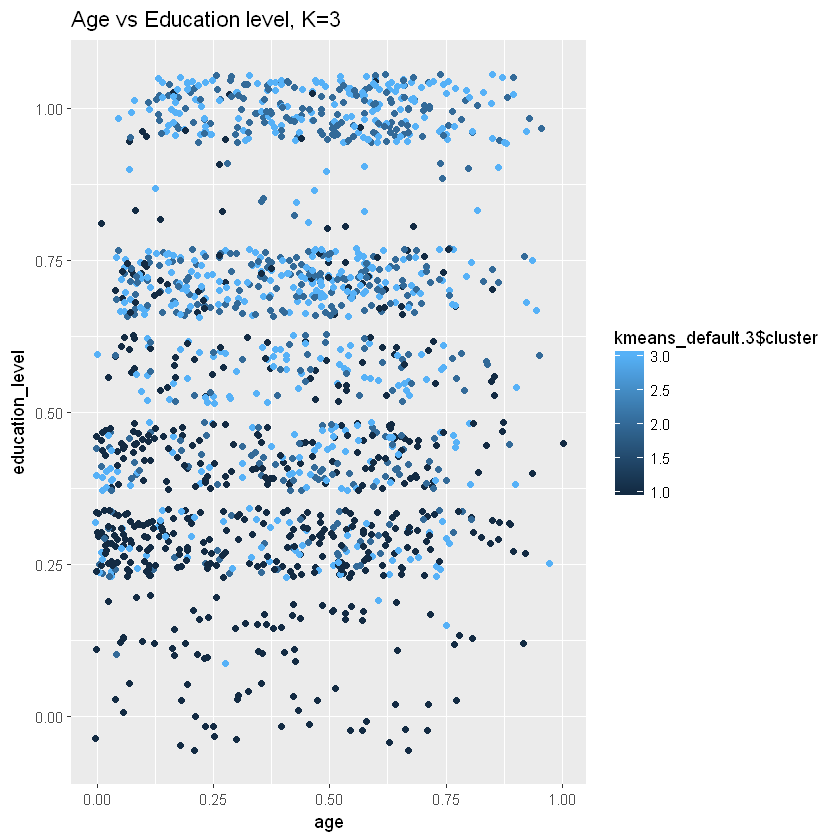

In [11]:
# plot(data.feature$education_level,data.feature$income,col=kmeans_default$cluster,main="How Kmeans seperated the data as clusetrs")
# plot(data.feature$education_level,data.feature$income,col=cl,main="How Kmeans seperated the data as clusetrs")
# ggplot(data.feature, aes(x=age, y=state,fill=cl)) +    geom_point() 
p1=qplot(age,education_level,colour=kmeans_default.3$cluster, data=data.feature, geom="jitter")+ 
ggtitle("Age vs Education level, K=3")
p1

# Cluster Analysis 1:  

As expected lower values of age and income are dominated in lower levels of clusters. Cluster 1 contains mostly individuals with lower education level

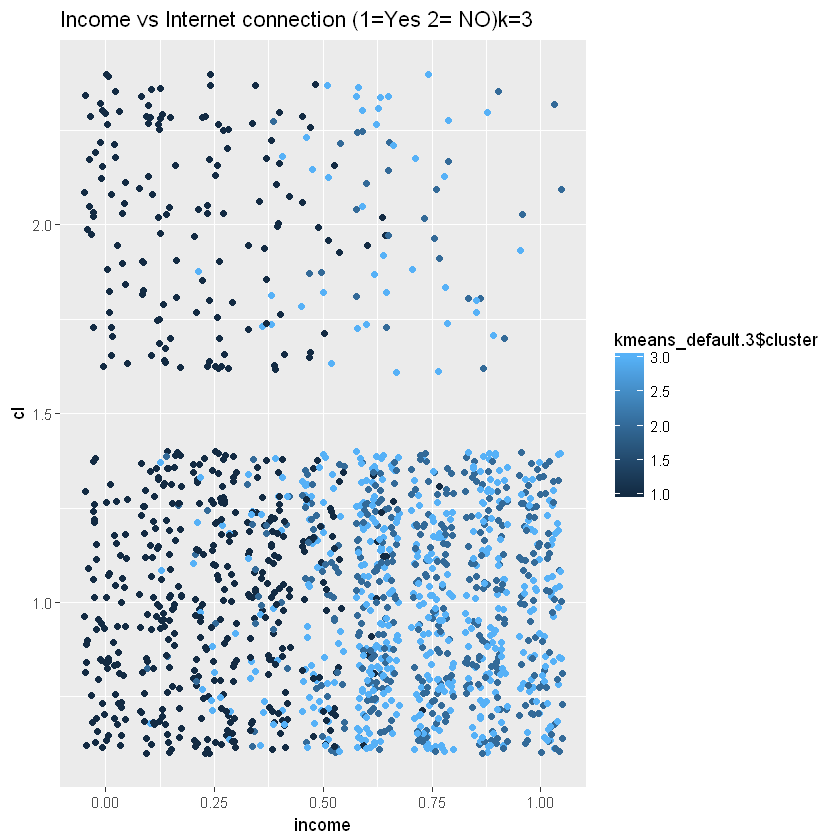

In [12]:
p2=qplot(income,cl,colour=kmeans_default.3$cluster, data=data.feature, geom="jitter")+ 
ggtitle("Income vs Internet connection (1=Yes 2= NO)k=3")
p2

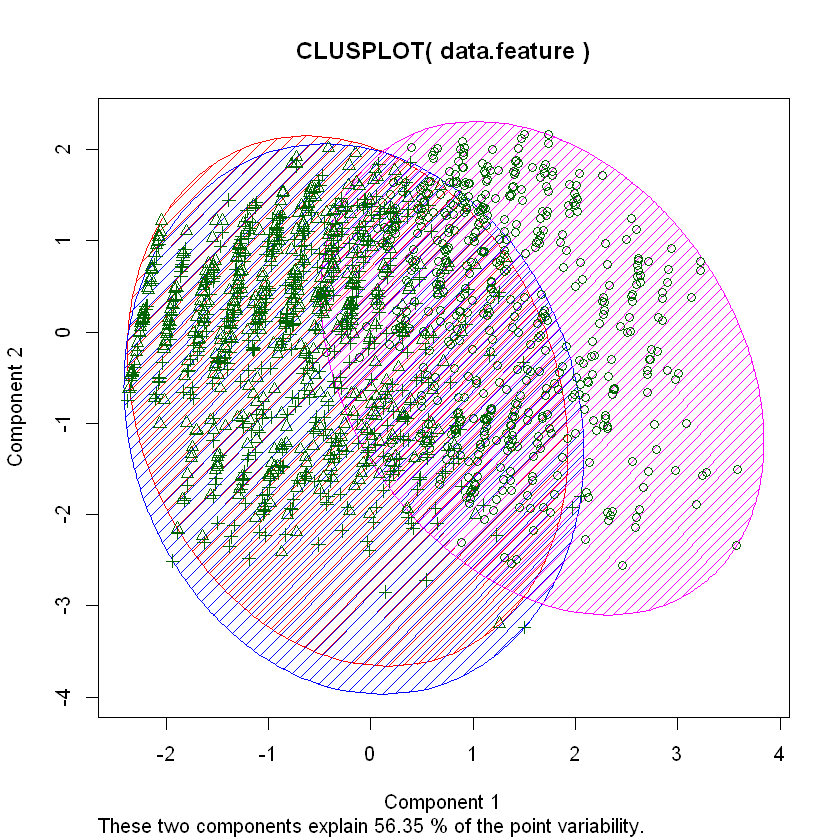

In [13]:
clusplot(data.feature, kmeans_default.3$cluster, color=TRUE, shade=TRUE, 
   labels=1, lines=0)

# Cluster Analysis 2:  

 Most of the people with higher income  having internet connection fall into  cluster 1

# Now analyzing for K=5

In [14]:
kmeans_default.5=kmeans.gjb<-kmeans(data.feature,5)
summary(kmeans_default.5)

             Length Class  Mode   
cluster      1472   -none- numeric
centers        25   -none- numeric
totss           1   -none- numeric
withinss        5   -none- numeric
tot.withinss    1   -none- numeric
betweenss       1   -none- numeric
size            5   -none- numeric
iter            1   -none- numeric
ifault          1   -none- numeric

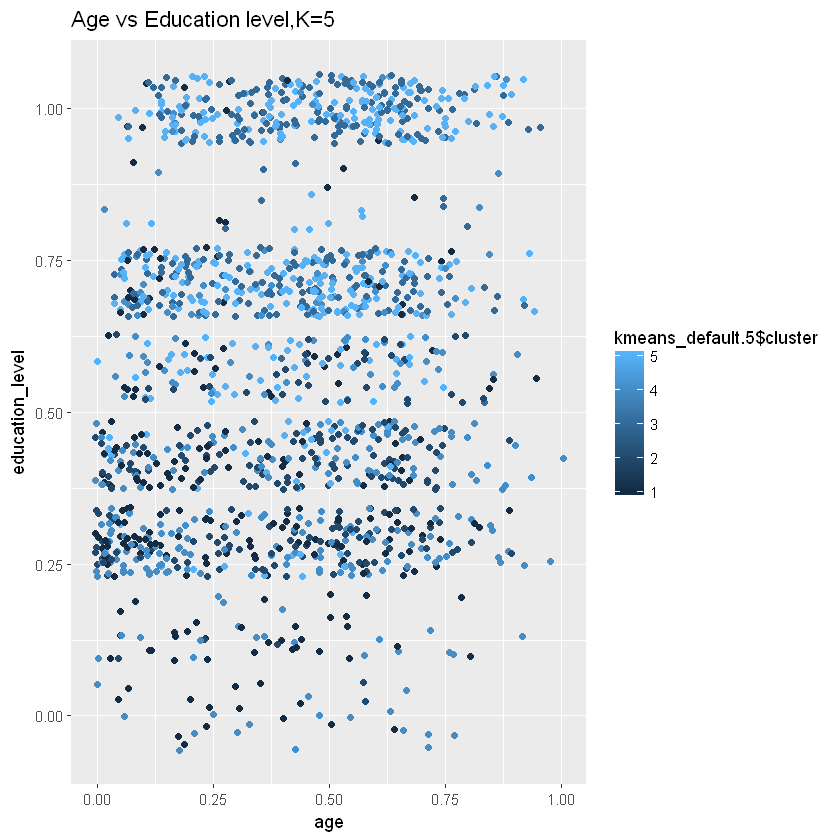

In [15]:
p3=qplot(age,education_level,colour=kmeans_default.5$cluster, data=data.feature, geom="jitter")+ 
ggtitle("Age vs Education level,K=5")
p3

# Cluster Analysis 3:

Middle education levels are dominated in higher cluster

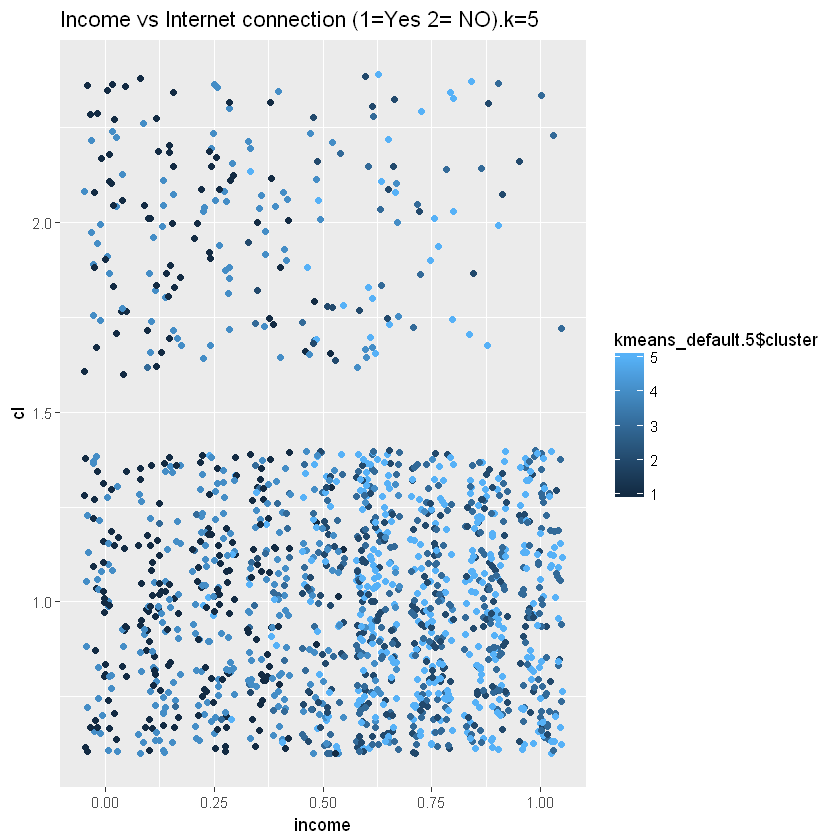

In [16]:
p4<-qplot(income,cl,colour=kmeans_default.5$cluster, data=data.feature, geom="jitter")+ 
ggtitle("Income vs Internet connection (1=Yes 2= NO).k=5")

p4

# Cluster Analysis 4:

High income levels having internet connection dominate cluster 1. The seperation between data in cluster are visualy appealing since the clustered data produce discriminitative boundary

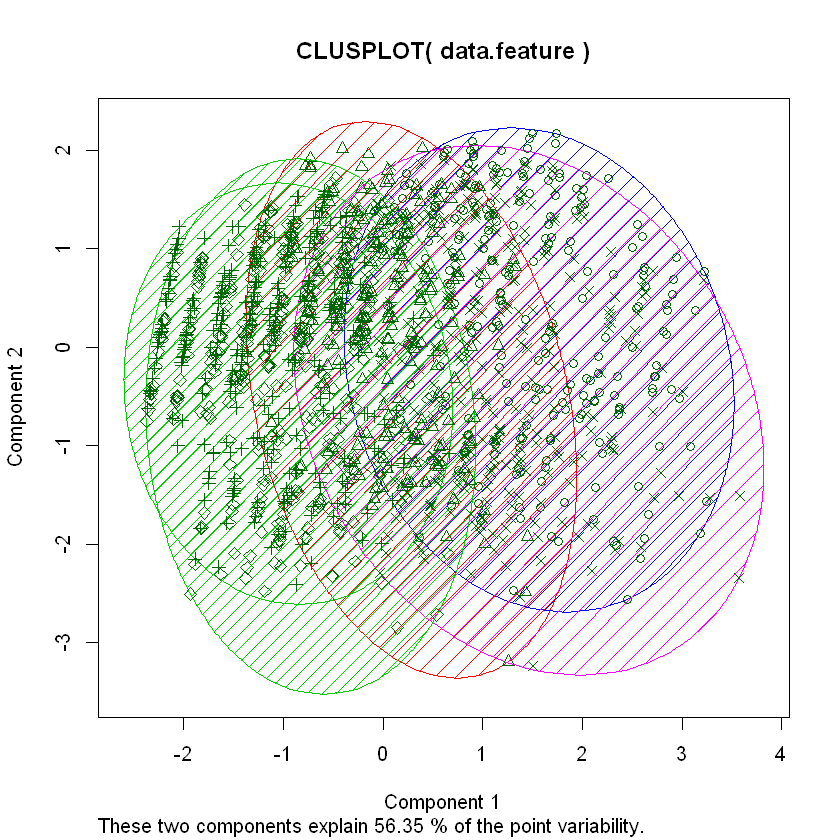

In [17]:
clusplot(data.feature, kmeans_default.5$cluster, color=TRUE, shade=TRUE, 
   labels=1, lines=0)

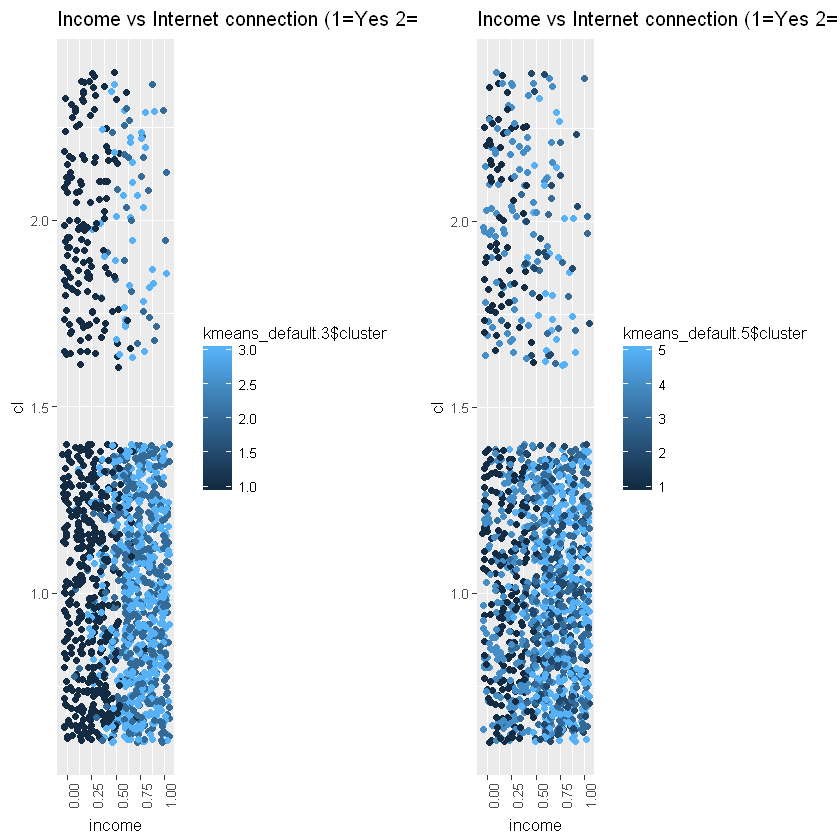

In [18]:
p5=p2+
theme(text = element_text(size=10),axis.text.x = element_text(angle=90, hjust=1))
p6=p4+theme(text = element_text(size=10),axis.text.x = element_text(angle=90, hjust=1))
grid.arrange(p5, p6, ncol=2)

# Cluster Analysis 5 :

The above analysis shows that individuals with high income and having internet connection are more likely to fall 
into cluster 1 when we have 3 clusters.The segregration is clear.  This changes when we increase the cluster size. On increasing the cluster size to 5. The boundry line fuzes into low income group

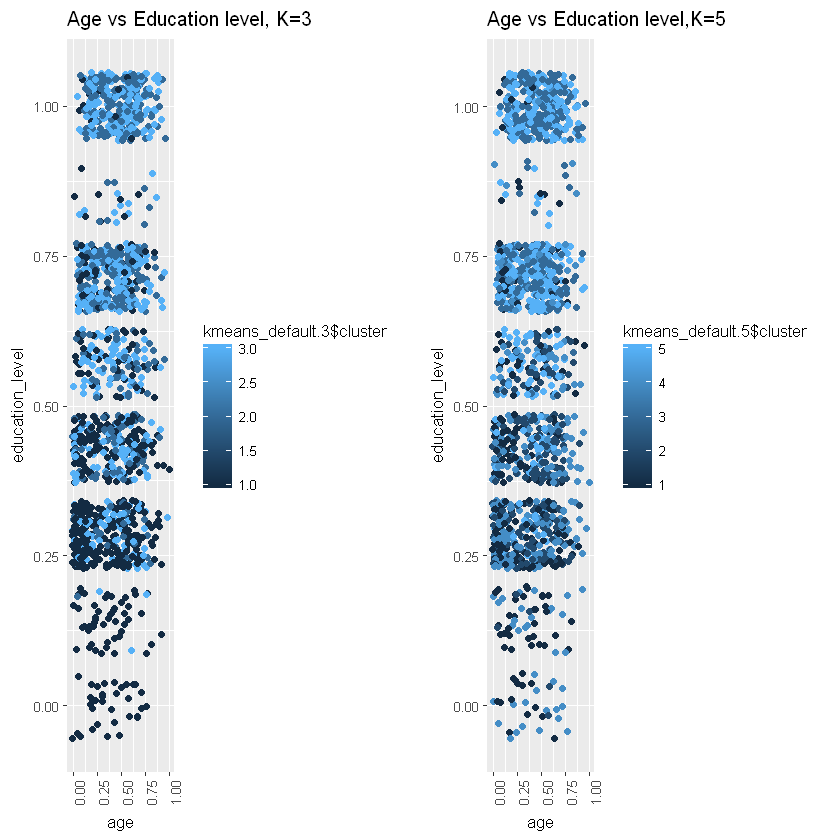

In [19]:
p7=p1+
theme(text = element_text(size=10),axis.text.x = element_text(angle=90, hjust=1))
p8=p3+theme(text = element_text(size=10),axis.text.x = element_text(angle=90, hjust=1))
grid.arrange(p7, p8, ncol=2)

# Cluster Analysis 6 :

We can observe that when k is 3 , high education group dominates cluster 3 while when k=5 the high education group is dominated in cluster 1

Observing cluster characterstics

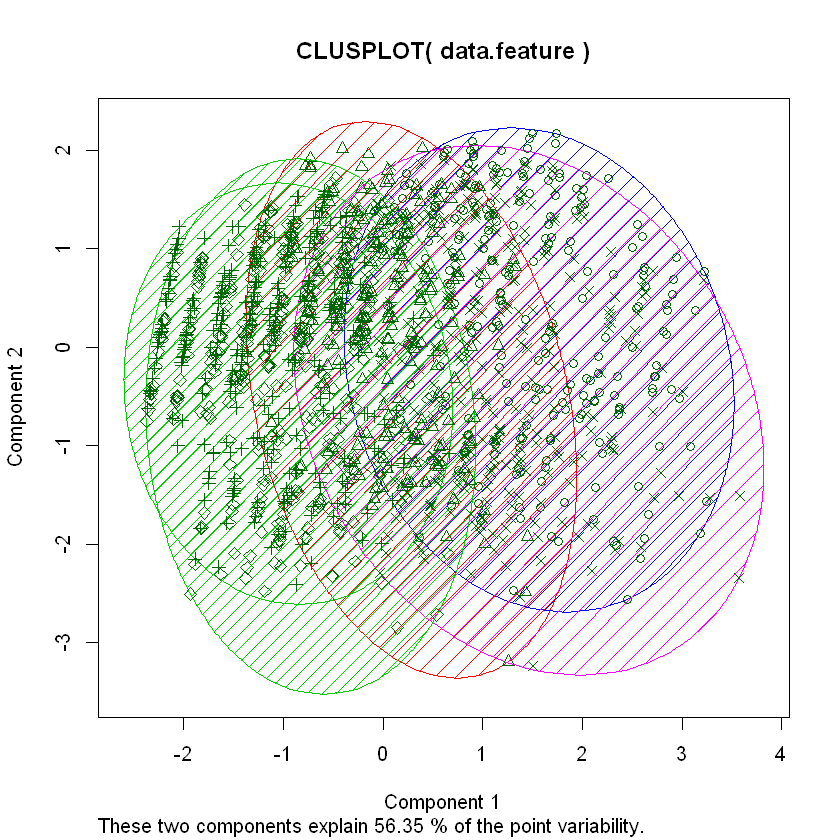

In [20]:
library(cluster) 
clusplot(data.feature, kmeans_default.5$cluster, color=TRUE, shade=TRUE, 
   labels=1, lines=0)

# Cluster Analysis 7 : 


With k=5 the the overlap between cluster decreases then that with k=3

# Cluster Analysis 8 :

In [21]:
kmeans_default.3$centers

,age,state,education_level,emplnw,income
1,0.3605324,0.4722470,0.3746631,0.2269542,0.2245283
2,0.4441687,0.2270642,0.7169069,0.1159895,0.7462729
3,0.4282582,0.7623069,0.6990401,0.1312818,0.7094862


In [22]:
table(kmeans_default.3$cluster)


  1   2   3 
530 436 506 

Cluster 3 seems to be heavy on low income and low age group individuals. Its percieved that low age group are with low income. While, cluster 1 is dominated with individuals with high education level and high income and higher age. Conceptually it comes to be true since, more the education level more the income in general. Also, the lower values of emplnw falls in cluster 1 , which means they are either fully employed, part time or retired. 2nd cluster has mostly over lap of other 1st and third.

# Cluster Analysis 9:

In [23]:
kmeans_default.3

K-means clustering with 3 clusters of sizes 530, 436, 506

Cluster means:
        age     state education_level    emplnw    income
1 0.3605324 0.4722470       0.3746631 0.2269542 0.2245283
2 0.4441687 0.2270642       0.7169069 0.1159895 0.7462729
3 0.4282582 0.7623069       0.6990401 0.1312818 0.7094862

Clustering vector:
   [1] 2 3 1 2 3 2 2 2 2 2 1 2 3 3 1 2 2 3 3 1 1 3 3 1 1 1 1 1 1 2 1 1 2 2 3 3 2
  [38] 1 3 3 1 3 1 3 1 2 2 3 2 3 2 3 3 1 2 3 3 1 2 2 3 1 1 3 1 3 3 1 1 2 3 3 2 3
  [75] 3 2 2 1 3 1 1 1 1 2 2 1 1 2 2 3 1 1 3 2 2 1 2 1 1 3 3 3 2 3 2 3 1 1 3 3 3
 [112] 3 2 2 3 2 2 3 1 2 1 1 3 3 3 3 2 2 3 1 2 3 3 1 3 3 2 3 1 2 2 2 1 1 2 3 1 2
 [149] 2 3 2 1 2 3 3 3 2 1 3 3 1 2 3 1 2 1 3 2 2 2 3 3 3 3 1 2 2 2 2 3 2 2 3 3 2
 [186] 3 3 1 1 3 1 1 3 2 1 2 1 1 1 2 3 3 2 3 1 1 1 2 3 2 1 3 3 1 1 3 2 3 3 2 2 2
 [223] 3 2 1 2 1 2 1 2 3 2 1 3 3 2 3 3 3 2 1 1 3 3 3 1 3 3 2 3 2 2 3 2 3 3 1 2 1
 [260] 3 2 3 2 3 3 3 1 3 2 2 2 2 1 1 2 2 1 1 3 2 1 3 1 2 2 3 2 1 3 3 2 2 1 2 1 3
 [297] 3 3 1 1 2 3 3 1 1 1

<i>(between_SS / total_SS =  37.9 %)</i>

What we want is to minimize the within group dispersion (given by total ss-> dispersions among centroids of each group to the global centroid )and maximize the between-group dispersion (dispersion within each group:  how close the samples in a group are to the centroid within that group ).
The higher this ratio is the better.
We have achieved a reduction in sums of squares by 38%. This is not a good estimate as a classifier.
It can also be viewed from the clustplot that the groups overlap alot.

# Cluster Analysis 10 :

In [24]:
kmeans_default.5$centers

,age,state,education_level,emplnw,income
1,0.3225001,0.2287817,0.3857721,0.2463852,0.1842105
2,0.4217042,0.3249374,0.3872870,0.1369594,0.7161697
3,0.4508178,0.2361812,0.8619207,0.1046345,0.7449833
4,0.4005278,0.7510147,0.4045435,0.2210572,0.2828746
5,0.4306619,0.7650203,0.7746532,0.1128609,0.7519685


In [25]:
table(kmeans_default.5$cluster)


  1   2   3   4   5 
247 218 299 327 381 

In [26]:
kmeans_default.5

K-means clustering with 5 clusters of sizes 247, 218, 299, 327, 381

Cluster means:
        age     state education_level    emplnw    income
1 0.3225001 0.2287817       0.3857721 0.2463852 0.1842105
2 0.4217042 0.3249374       0.3872870 0.1369594 0.7161697
3 0.4508178 0.2361812       0.8619207 0.1046345 0.7449833
4 0.4005278 0.7510147       0.4045435 0.2210572 0.2828746
5 0.4306619 0.7650203       0.7746532 0.1128609 0.7519685

Clustering vector:
   [1] 2 5 1 3 5 2 2 2 1 3 1 3 5 5 4 3 3 5 5 1 4 5 4 1 4 1 4 4 1 2 1 2 3 3 5 5 3
  [38] 4 5 5 1 5 4 5 4 2 3 5 3 5 2 2 5 4 2 5 5 4 3 3 5 1 4 5 1 5 4 1 1 3 5 5 3 5
  [75] 5 3 3 4 4 4 4 4 4 3 2 4 4 3 2 2 1 4 5 2 3 4 2 4 4 5 5 5 3 5 2 5 4 4 2 4 3
 [112] 5 3 3 5 3 2 5 4 3 1 1 3 2 5 5 2 2 5 1 2 4 5 4 5 5 3 5 1 3 3 3 1 2 2 5 4 3
 [149] 3 5 2 4 3 4 4 5 3 1 5 5 1 2 5 1 3 4 4 3 2 3 5 5 5 5 1 2 3 3 3 5 2 3 5 5 2
 [186] 5 2 4 4 5 4 4 5 2 4 3 4 1 3 2 5 5 2 4 1 4 1 3 4 3 4 5 5 1 2 5 2 4 5 3 2 2
 [223] 5 3 1 3 1 3 4 3 5 3 4 5 4 3 2 4 5 3 4 1 2 5 5 4 5 5 3 4

In [27]:
result.df=data.frame(k=c(3,5),betweenSS_by_totalss=c(37.9,50.0),Normalization=c("Min Max","Min Max"))
result.df

k,betweenSS_by_totalss,Normalization
3,37.9,Min Max
5,50.0,Min Max


We were able to achieve better result using k=5, where the reduction in sums of squares is 50% as opposed to 38% with k=3. Most of the values fall in cluster 3 ad is highly dominated with high age and high education group individuals.
Although the overlap is reduced, but the dispersion between the centers of groups on the basis of employment status is not discernable.

# Although min max normalization managed to achieve reduction in sum of squares to 50%, this is still unsatisfatory.

##  Approach 2: Div normalization:


###  Following the same steps as above but with a different normalized dataframe

In [28]:
head(gjb.data.select)
summary(gjb.data.select)

age,state,education_level,emplnw,income,internet_service_at_home
63,24,4,3,6,1
40,37,5,1,6,1
65,21,4,3,3,1
69,20,6,2,8,1
77,40,6,3,6,1
52,27,4,1,8,1


      age            state       education_level     emplnw     
 Min.   :18.00   Min.   : 1.00   Min.   :1.000   Min.   :1.000  
 1st Qu.:33.00   1st Qu.:13.00   1st Qu.:3.000   1st Qu.:1.000  
 Median :49.00   Median :29.00   Median :5.000   Median :1.500  
 Mean   :47.83   Mean   :28.46   Mean   :5.113   Mean   :2.128  
 3rd Qu.:61.00   3rd Qu.:42.00   3rd Qu.:6.000   3rd Qu.:3.000  
 Max.   :91.00   Max.   :56.00   Max.   :8.000   Max.   :8.000  
     income      internet_service_at_home
 Min.   :1.000   Min.   :1.000           
 1st Qu.:3.000   1st Qu.:1.000           
 Median :6.000   Median :1.000           
 Mean   :5.366   Mean   :1.139           
 3rd Qu.:7.000   3rd Qu.:1.000           
 Max.   :9.000   Max.   :2.000           

Since age is between 18 to 19 we can use divide normalization

In [29]:
div<-function(x)
 {
    t1<-x/10
    return(t1)
  }

In [30]:
gjb.data.select.divnormalized=gjb.data.select
gjb.data.select.divnormalized=as.data.frame(lapply(gjb.data.select[,1:2], div))%>%
                            data.frame(gjb.data.select[,3:6])#Normalize alll feature except label
lapply(gjb.data.select.divnormalized, unique)
head(gjb.data.select.divnormalized)

$age
 [1] 6.3 4.0 6.5 6.9 7.7 5.2 7.4 4.4 8.7 5.8 3.1 7.0 3.6 3.9 8.5 7.6 6.6 5.7 1.9
[20] 2.8 4.9 4.5 7.5 6.0 6.7 8.0 7.3 8.1 5.1 7.8 6.1 3.7 4.3 8.2 7.2 5.9 5.6 9.1
[39] 5.4 3.4 5.5 6.2 4.6 3.3 8.3 2.2 5.3 1.8 7.9 7.1 6.4 8.6 3.5 2.1 6.8 5.0 3.2
[58] 4.8 2.6 2.7 8.4 4.7 3.0 4.2 2.0 8.9 3.8 2.4 8.8 2.5 2.3 2.9 4.1

$state
 [1] 2.4 3.7 2.1 2.0 4.0 2.7 1.2 0.1 0.5 3.0 0.9 5.1 4.9 5.3 4.1 0.6 3.9 5.5 2.9
[20] 2.3 2.6 1.5 4.2 3.4 5.4 1.7 3.6 4.8 4.6 3.5 1.8 2.5 3.3 3.1 4.5 1.3 4.7 3.8
[39] 1.9 3.2 0.4 2.2 0.2 4.4 0.8 1.1 5.0 2.8 1.0 1.6 5.6

$education_level
[1] 4 5 6 3 8 7 2 1

$emplnw
[1] 3 1 2 4 6 5 7 8

$income
[1] 6 3 8 7 4 2 9 1 5

$internet_service_at_home
[1] 1 2

age,state,education_level,emplnw,income,internet_service_at_home
6.3,2.4,4,3,6,1
4.0,3.7,5,1,6,1
6.5,2.1,4,3,3,1
6.9,2.0,6,2,8,1
7.7,4.0,6,3,6,1
5.2,2.7,4,1,8,1


In [31]:
data.feature.divnormalized=data.frame(gjb.data.select.divnormalized[,3:6],age=gjb.data.select.divnormalized[,1])
summary(data.feature.divnormalized)

 education_level     emplnw          income      internet_service_at_home
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :1.000           
 1st Qu.:3.000   1st Qu.:1.000   1st Qu.:3.000   1st Qu.:1.000           
 Median :5.000   Median :1.500   Median :6.000   Median :1.000           
 Mean   :5.113   Mean   :2.128   Mean   :5.366   Mean   :1.139           
 3rd Qu.:6.000   3rd Qu.:3.000   3rd Qu.:7.000   3rd Qu.:1.000           
 Max.   :8.000   Max.   :8.000   Max.   :9.000   Max.   :2.000           
      age       
 Min.   :1.800  
 1st Qu.:3.300  
 Median :4.900  
 Mean   :4.783  
 3rd Qu.:6.100  
 Max.   :9.100  

The min max range of all the columns fall in the requisite range

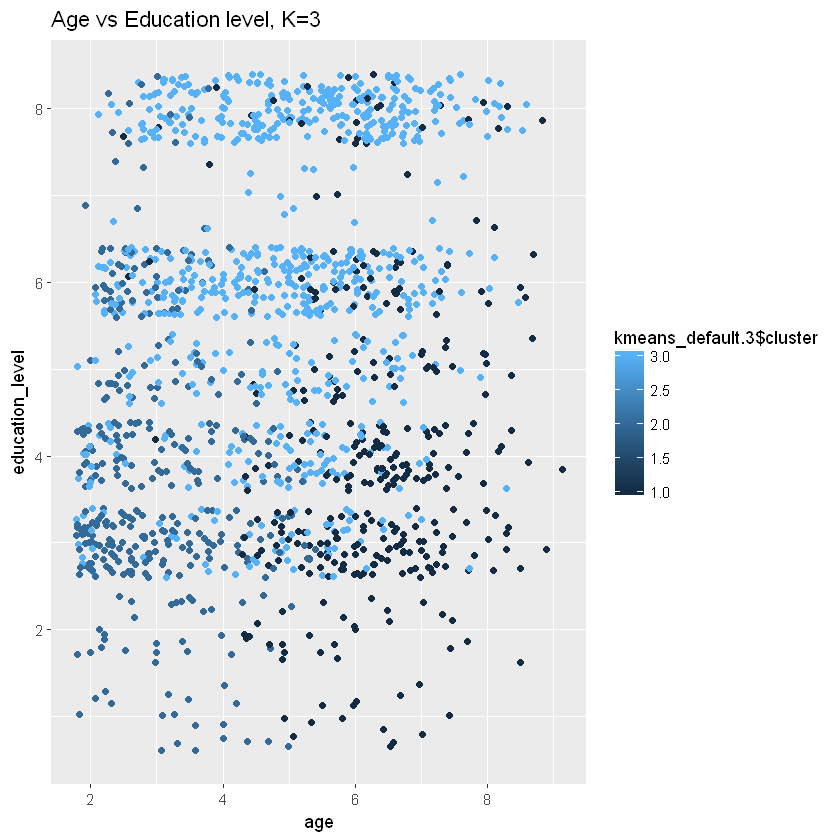

In [32]:
kmeans_default.3=kmeans.gjb<-kmeans(data.feature.divnormalized,3)
# summary(kmeans_default.3)
p1=qplot(age,education_level,colour=kmeans_default.3$cluster, data=data.feature.divnormalized, geom="jitter")+ 
ggtitle("Age vs Education level, K=3")
p1

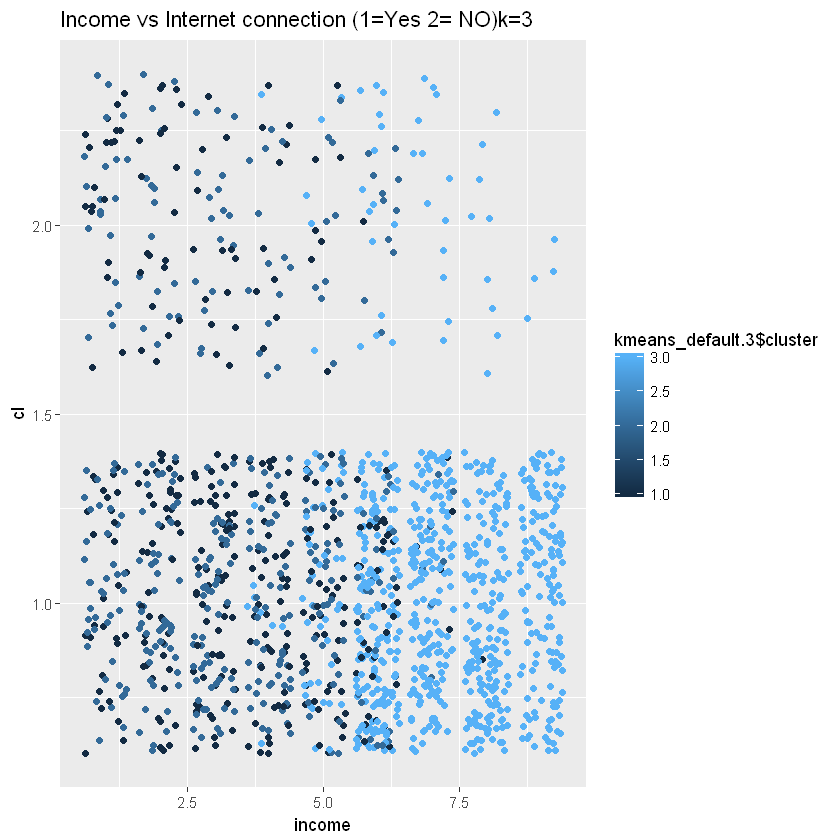

In [33]:
p2=qplot(income,cl,colour=kmeans_default.3$cluster, data=data.feature.divnormalized, geom="jitter")+ 
ggtitle("Income vs Internet connection (1=Yes 2= NO)k=3")
p2


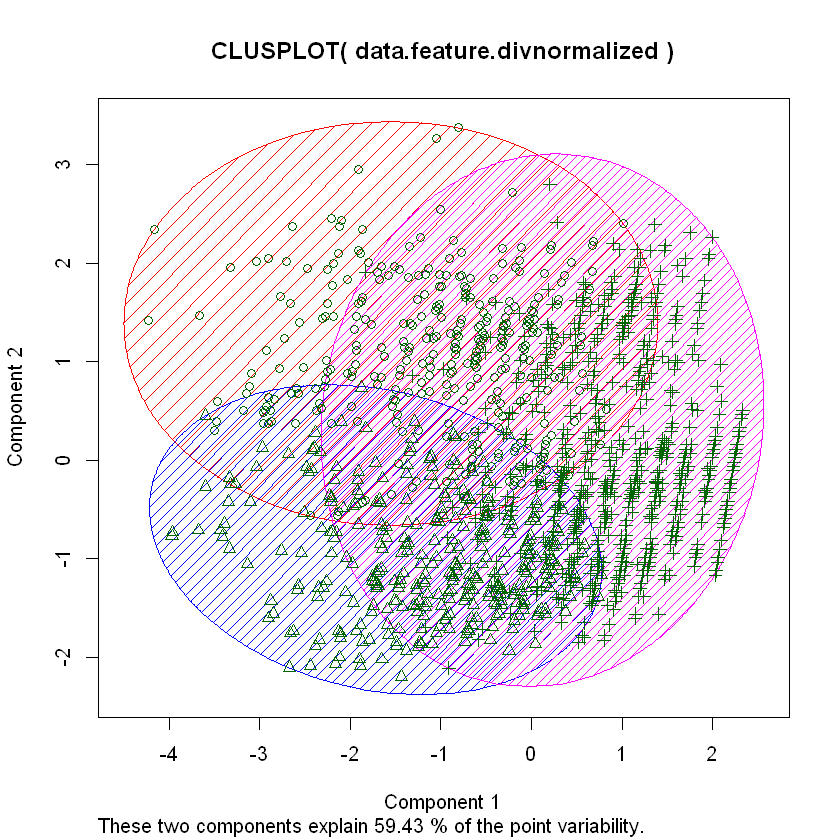

In [34]:
clusplot(data.feature.divnormalized, kmeans_default.3$cluster, color=TRUE, shade=TRUE, 
   labels=1, lines=0)

In [35]:
kmeans_default.3

K-means clustering with 3 clusters of sizes 346, 365, 761

Cluster means:
  education_level   emplnw   income internet_service_at_home      age
1        4.130058 3.231214 3.387283                 1.205202 6.274566
2        3.808219 1.863014 3.290411                 1.238356 3.034247
3        6.185283 1.754271 7.261498                 1.061761 4.942970

Clustering vector:
   [1] 1 3 1 3 3 3 1 3 1 3 2 3 3 3 1 3 3 3 3 2 2 3 2 1 1 1 1 1 1 1 2 1 3 3 3 3 3
  [38] 1 3 3 1 3 1 3 1 1 3 3 3 3 3 3 3 1 3 3 3 2 3 3 3 1 1 3 1 3 1 1 1 3 3 3 3 3
  [75] 3 3 3 1 1 1 1 1 2 3 3 1 1 3 1 1 1 1 3 2 1 1 1 1 1 3 3 1 3 3 3 3 1 2 3 1 3
 [112] 3 3 3 3 1 3 3 2 3 1 1 3 3 3 3 1 3 3 1 3 1 3 1 3 3 3 3 2 3 3 3 1 2 1 3 2 3
 [149] 3 1 3 1 3 1 1 3 1 1 3 3 2 3 3 1 3 1 1 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 3
 [186] 3 3 2 2 3 2 2 3 3 1 3 2 2 1 3 3 3 3 1 2 1 1 3 2 3 1 3 1 2 1 3 1 2 3 3 3 3
 [223] 3 3 1 3 1 3 1 3 3 3 1 3 1 3 3 1 3 3 1 1 1 3 3 2 3 3 3 1 2 3 1 3 3 3 1 2 1
 [260] 1 3 2 3 3 1 3 2 1 3 3 3 3 2 1 3 3 2 2 3 1 1 3 2 3 3 

In [36]:
kmeans_default.5=kmeans.gjb<-kmeans(data.feature.divnormalized,5)
# summary(kmeans_default.3)



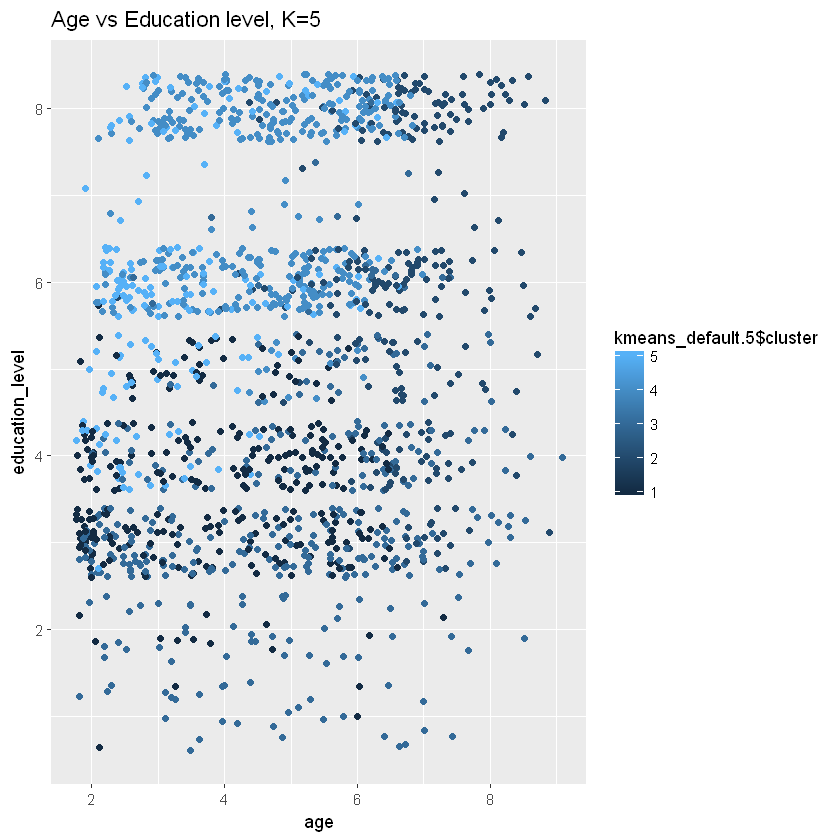

In [37]:
p1=qplot(age,education_level,colour=kmeans_default.5$cluster, data=data.feature.divnormalized, geom="jitter")+ 
ggtitle("Age vs Education level, K=5")
p1

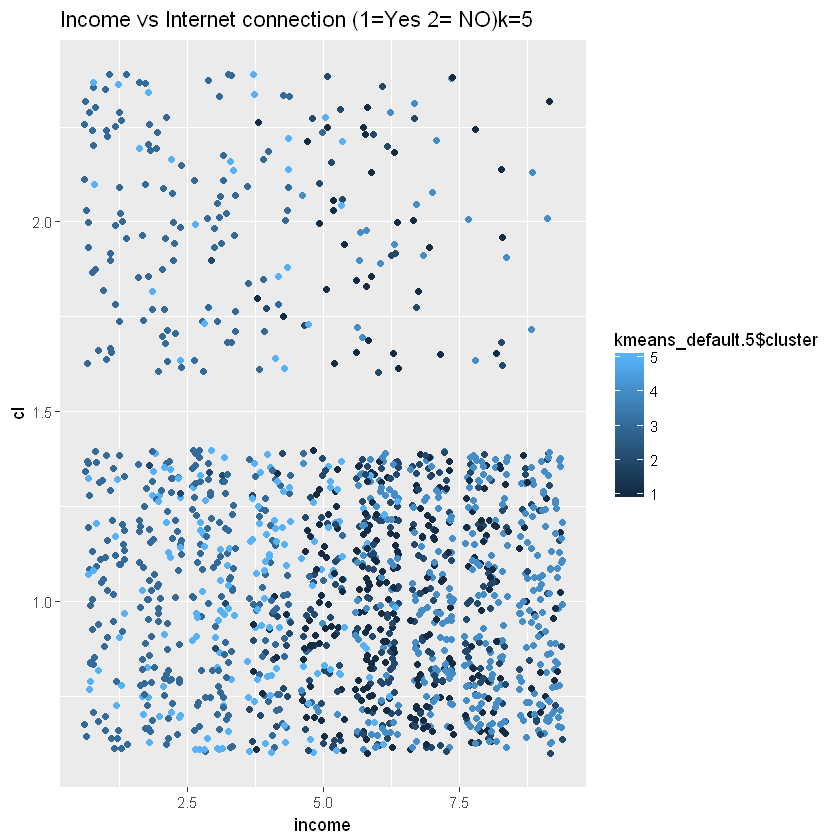

In [38]:

p2=qplot(income,cl,colour=kmeans_default.5$cluster, data=data.feature.divnormalized, geom="jitter")+ 
ggtitle("Income vs Internet connection (1=Yes 2= NO)k=5")
p2

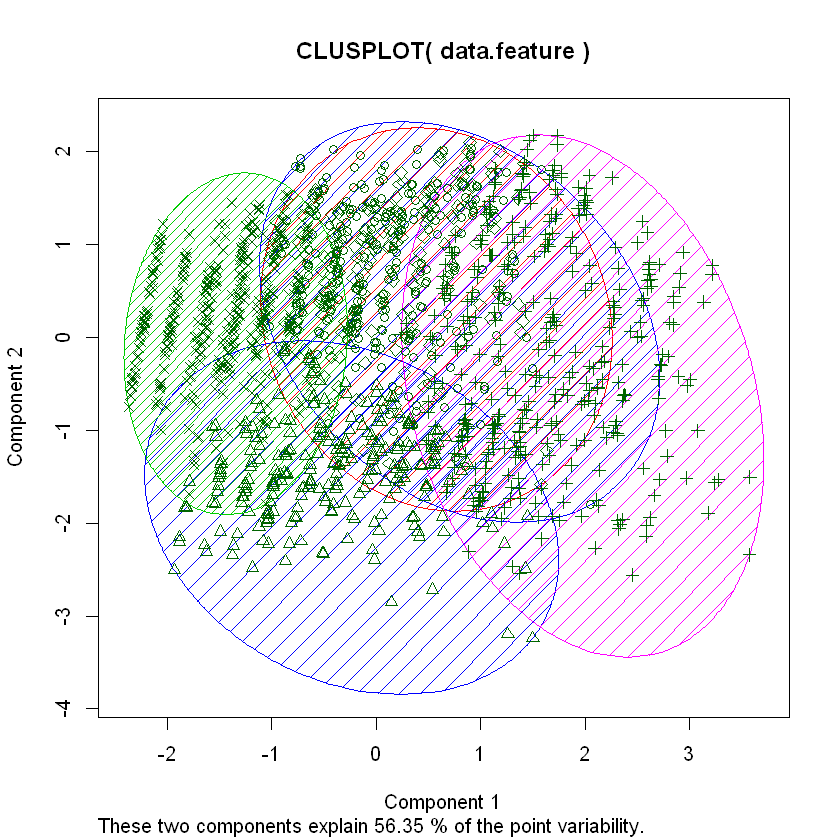

In [39]:
clusplot(data.feature, kmeans_default.5$cluster, color=TRUE, shade=TRUE, 
   labels=1, lines=0)

In [40]:
kmeans_default.5

K-means clustering with 5 clusters of sizes 286, 258, 367, 372, 189

Cluster means:
  education_level   emplnw   income internet_service_at_home      age
1        3.622378 1.681818 6.527972                 1.118881 3.952797
2        6.034884 3.143411 6.368217                 1.073643 6.762791
3        3.256131 2.942779 2.400545                 1.291553 4.892371
4        7.008065 1.231183 7.634409                 1.056452 4.650538
5        5.984127 1.603175 3.534392                 1.126984 3.382540

Clustering vector:
   [1] 2 1 3 2 2 1 2 1 2 4 3 2 4 2 3 2 4 2 2 3 3 2 5 3 3 3 3 3 3 2 5 2 2 4 2 4 2
  [38] 3 4 4 3 4 2 4 3 2 2 2 2 2 1 1 2 3 4 4 1 5 4 4 2 3 3 1 3 2 2 3 3 4 4 4 4 4
  [75] 2 4 4 3 2 3 3 3 5 4 1 3 3 4 2 2 3 3 5 1 2 3 2 3 3 4 2 2 4 4 1 2 3 3 1 2 2
 [112] 4 2 2 2 2 1 4 1 2 3 3 4 1 2 2 2 1 2 3 1 2 2 1 2 2 2 1 3 2 4 2 3 1 2 4 3 4
 [149] 2 5 1 3 2 2 3 2 5 3 2 2 5 1 2 3 2 2 2 2 1 5 2 4 2 4 3 2 2 2 4 2 1 4 1 2 2
 [186] 2 1 3 1 2 3 3 4 2 3 2 5 3 2 1 4 2 1 2 3 3 3 2 1 4 3 2 5 3 3 4 2 

In [41]:
result.df=data.frame(k=c(3,3,5,5),betweenSS_by_totalss=c(37.9,45.7,50.0,59),Normalization=c("Min Max","Divide by 10","Min Max", "Divide by 10"))
result.df

k,betweenSS_by_totalss,Normalization
3,37.9,Min Max
3,45.7,Divide by 10
5,50.0,Min Max
5,59.0,Divide by 10


# Cluster Analysis 11:

By changing the normalization method we managed to increase the betweenSS_by_totalss score in both the cases of k=3 and k=5. Thus it is very important to chose right normalization method while working with dataset with varying range in numerical features